# Comparative Analysis of 'dag2pag' Implementation with the DAG-to-PAG in Python Package 'causal-learn'


## An issue in the DAG-to-PAG conversion

In [ ]:
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import pandas as pd

def causal_learn_to_pcalg(adj: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a causal-learn style adjacency matrix to pcalg style.
    causal-learn: TAIL=-1, ARROW=1, CIRCLE=2, NULL=0
    pcalg:        TAIL=3,  ARROW=2, CIRCLE=1, NULL=0
    """
    mapping = {-1: 3, 1: 2, 2: 1, 0: 0}
    return adj.replace(mapping)

# Generate a random DAG with latent variables
ER_graph_gen = ErdosRenyi(num_nodes=7, expected_degree=2, def_dataframe=True, seed=321)
graph = ER_graph_gen.get_random_graph()
adj = ER_graph_gen.set_latent_nodes(graph, num_latent=1, selection_bias=False)
latent_nodes = [node for node in adj.columns if node.startswith('L')]

# Convert DAG to PAG using causal-learn
pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes)
pag1 = causal_learn_to_pcalg(pag1)  # Convert to pcalg style

# Convert DAG to PAG using FastDAG2PAG
pag2 = dag2pag(adj, latent_nodes=latent_nodes)['PAG.DataFrame']

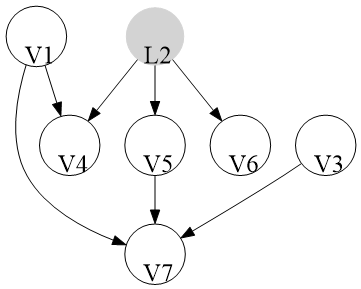

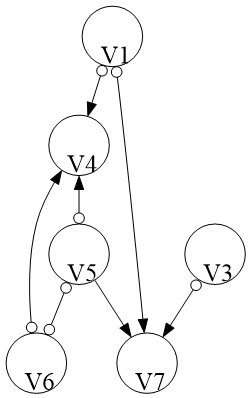

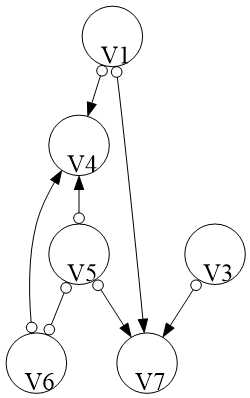

In [ ]:
# Visualize the generated DAG and the resulting PAGs from both methods
from fastdag2pag.mixgraph import MixGraph
from IPython.display import Image, display

# Visualize the original DAG
dag = MixGraph()
dag.from_pandas_adjacency(adj, graph_type='DAG')
dag_pydot = dag.to_pydot()
png_bytes = dag_pydot.create_png()
display(Image(png_bytes))  

# Visualize PAG from causal-learn
Pag1 = MixGraph()
Pag1.from_pandas_adjacency(pag1, graph_type='MG')
Pag1_pydot = Pag1.to_pydot()
png_bytes_pag1 = Pag1_pydot.create_png()
display(Image(png_bytes_pag1))  

# Visualize PAG from FastDAG2PAG
Pag2 = MixGraph()
Pag2.from_pandas_adjacency(pag2, graph_type='MG')
Pag2_pydot = Pag2.to_pydot()
png_bytes_pag2 = Pag2_pydot.create_png()
display(Image(png_bytes_pag2))  

## Observed Difference in Edge Orientation

From the above comparison, we observe that the edge between nodes V5 and V7 is oriented as `->` in DAG-to-PAG, but as `o->` in FastDAG2PAG. This discrepancy arises because the `existsSemiDirectedPath` function in causal-learn (version 0.1.4.1) is not for checking the existence of uncovered pd-paths, as noted in their own comments. Additionally, the current version incorrectly identifies the path <V6, V5, V7> as a valid uncovered pd-path for rule 9.

## Efficiency and Consistency Comparison

Next, we compare the skeleton learning efficiency and output consistency between FastDAG2PAG and the DAG-to-PAG.

In [ ]:
# Benchmarking: Compare runtime and output consistency for different node sizes
import numpy as np
import pandas as pd
import time
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import matplotlib.pyplot as plt

def binarize_adj(adj: pd.DataFrame) -> pd.DataFrame:
    """Convert all nonzero elements of the adjacency matrix to 1, keep 0 unchanged."""
    return (adj != 0).astype(int)

node_sizes = [5, 6, 7, 8, 9]
num_trials = 5
results = []

for n_nodes in node_sizes:
    dag2pag_times = []
    dag_to_pag_times = []
    match_count = 0
    for trial in range(num_trials):
        # Generate random DAG adjacency matrix
        ER_graph_gen = ErdosRenyi(n_nodes, expected_degree=2, def_dataframe=True, seed=321)
        graph = ER_graph_gen.get_random_graph()
        num_latent = int(n_nodes * 0.1) if n_nodes >= 10 else 1
        adj = ER_graph_gen.set_latent_nodes(graph, num_latent=num_latent, selection_bias=False)
        latent_nodes = [node for node in adj.columns if node.startswith('L')]

        # DAG_to_PAG (causal-learn)
        t0 = time.time()
        pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes)
        t1 = time.time()
        dag_to_pag_times.append(t1 - t0)

        # FastDAG2PAG
        t2 = time.time()
        pag2 = dag2pag(adj, latent_nodes=latent_nodes)['PAG.DataFrame']
        t3 = time.time()
        dag2pag_times.append(t3 - t2)

        # Compare outputs (matrix equality, ignoring edge marks)
        if binarize_adj(pag1).equals(binarize_adj(pag2)):
            match_count += 1
        else:
            print(f"Discrepancy found in graph {n_nodes}-{trial+1}")
            diff = pag1.compare(pag2, result_names=("DAG_to_PAG", "fastdag2pag"))
            print(diff)

    results.append({
        'nodes': n_nodes,
        'dag_to_pag_avg_time': np.mean(dag_to_pag_times),
        'fastdag2pag_avg_time': np.mean(dag2pag_times),
        'match_ratio': match_count / num_trials
    })

results_df = pd.DataFrame(results)
print('Match ratio (PAG matrix equality) for each node size:')
for index, row in results_df.iterrows():
    print(f"Node Size: {row['nodes']}, Match Ratio: {row['match_ratio']:.2f}")


























Match ratio (PAG matrix equality) for each node size:



Match ratio (PAG matrix equality) for each node size:


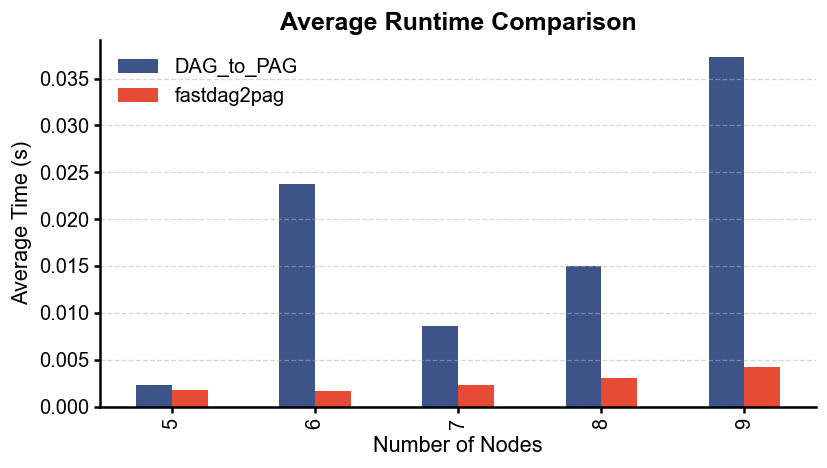

In [ ]:
# Plot the average runtime comparison between the two methods
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

# Nature-style color palette
nature_colors = ['#3C5488', '#E64B35']
ax = results_df.plot(x='nodes', y=['dag_to_pag_avg_time', 'fastdag2pag_avg_time'], kind='bar',
                    color=nature_colors,
                    edgecolor='none',
                    figsize=(7,4),
                    legend=True)
ax.set_ylabel('Average Time (s)', fontsize=13, fontname='Arial')
ax.set_xlabel('Number of Nodes', fontsize=13, fontname='Arial')
ax.set_title('Average Runtime Comparison', fontsize=15, fontweight='bold', fontname='Arial')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(['DAG_to_PAG', 'fastdag2pag'], fontsize=12, frameon=False)
ax.set_xticklabels(results_df['nodes'], rotation=90, fontsize=12, fontname='Arial')
ax.tick_params(axis='y', labelsize=12, width=1.5)
ax.tick_params(axis='x', width=1.5)
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()